## Detecting Twitter Bots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['patch.force_edgecolor'] = True
import seaborn as sns
import warnings
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
import random
# Change this to your path
path = "change/this/path/"
training_data = pd.read_csv(f"{path}/twitter_dataset.csv",lineterminator='\n')
bots = training_data[training_data.bot==1]
nonbots = training_data[training_data.bot==0]

training_data

,Unnamed: 0.1,Unnamed: 0,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,...,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,bot,listed_count
0,0,0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,...,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,1,319
1,1,1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,...,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,0,768
2,2,2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,...,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,0,890
3,3,3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,...,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,0,645
4,4,4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,...,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,0,704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37433,37433,37433,2009-08-08 13:11:15,True,False,"Role: Stock Taker. Past Roles: Nanny, Sales As...",651,139,1105,False,...,Kingston Upon Hull,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/5844684414...,butchsekab,340,False,0.084,4028,0,364
37434,37434,37434,2013-01-05 21:35:37,False,False,KINGDOM LANDLORD #FreeCornBread,8839,1121486,605,True,...,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9511349456...,Mathieu_Era,24970,True,8.976,2782,0,416
37435,37435,37435,2013-01-14 18:05:54,True,False,Bienvenid@s al Twitter Oficial de Sergio Dalma...,399,85630,190,False,...,En constante movimiento,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1174733822...,SDalmaoficial,6174,True,2.226,2773,0,128
37436,37436,37436,2012-09-10 16:12:02,False,False,Just a good guy wrapped up in a bad system.\nA...,967,138,166,True,...,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme14/bg.gif,http://pbs.twimg.com/profile_images/1265807908...,VinceYearly,982,False,0.339,2899,0,158


### Exploratory Data Analysis

#### Identifying Missingness in the data

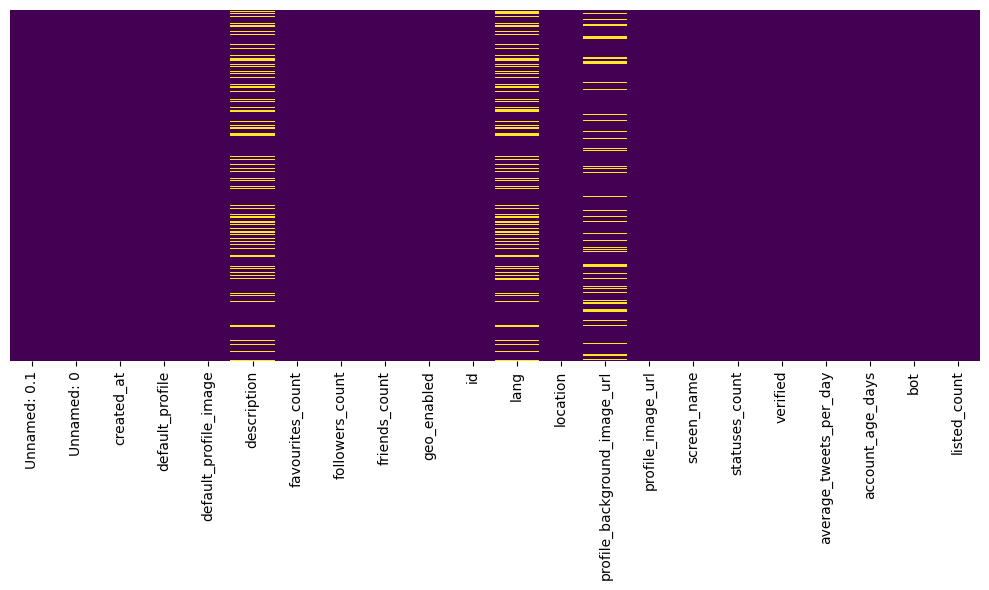

In [3]:
def get_heatmap(df):
    #This function gives heatmap of all NaN values
    plt.figure(figsize=(10,6))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.tight_layout()
    return plt.show()

get_heatmap(training_data)

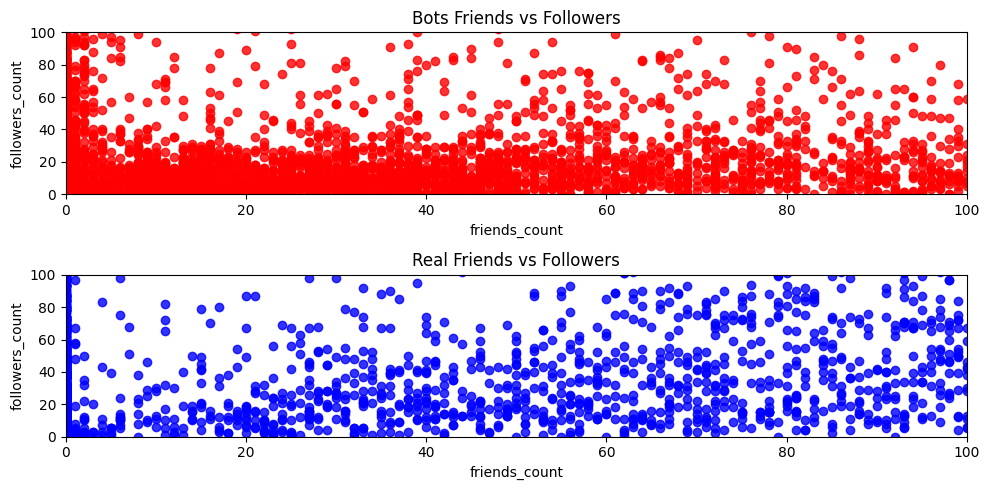

In [4]:
bots.friends_count/bots.followers_count

plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title('Bots Friends vs Followers')
sns.regplot(x=bots.friends_count, y=bots.followers_count, color='red', label='Bots')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

plt.subplot(2,1,2)
plt.title('Real Friends vs Followers')
sns.regplot(x=nonbots.friends_count, y=nonbots.followers_count, color='blue', label='NonBots')
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

#### Identifying Imbalance in the data

In [5]:
bots['friends_by_followers'] = bots.friends_count/bots.followers_count
bots[bots.friends_by_followers<1].shape

nonbots['friends_by_followers'] = nonbots.friends_count/nonbots.followers_count
nonbots[nonbots.friends_by_followers<1].shape

(15868, 23)

In [6]:
bots_listed_count_df = bots[bots.listed_count<16000]
nonbots_listed_count_df = nonbots[nonbots.listed_count<16000]

bots_verified_df = bots_listed_count_df[bots_listed_count_df.verified==False]
bots_screenname_has_bot_df_ = bots_verified_df[(bots_verified_df.screen_name.str.contains("bot", case=False)==True)].shape

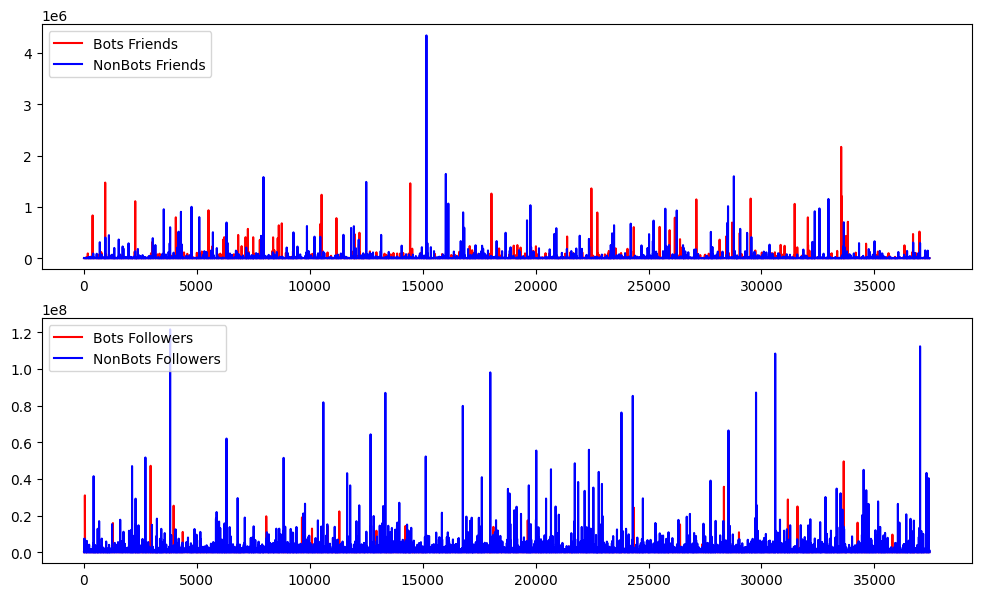

In [7]:
plt.figure(figsize=(12,7))

plt.subplot(2,1,1)
plt.plot(bots_listed_count_df.friends_count, color='red', label='Bots Friends')
plt.plot(nonbots_listed_count_df.friends_count, color='blue', label='NonBots Friends')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(bots_listed_count_df.followers_count, color='red', label='Bots Followers')
plt.plot(nonbots_listed_count_df.followers_count, color='blue', label='NonBots Followers')
plt.legend(loc='upper left')

In [8]:
condition = (bots.screen_name.str.contains("bot", case=False)==True)|(bots.description.str.contains("bot", case=False)==True)|(bots.location.isnull())|(bots.verified==False)

bots['screen_name_binary'] = (bots.screen_name.str.contains("bot", case=False)==True)
bots['location_binary'] = (bots.location.isnull())
bots['verified_binary'] = (bots.verified==False)
bots.shape

(12425, 26)

In [9]:
condition = (nonbots.screen_name.str.contains("bot", case=False)==False)| (nonbots.description.str.contains("bot", case=False)==False) |(nonbots.location.isnull()==False)|(nonbots.verified==True)

nonbots['screen_name_binary'] = (nonbots.screen_name.str.contains("bot", case=False)==False)
nonbots['location_binary'] = (nonbots.location.isnull()==False)
nonbots['verified_binary'] = (nonbots.verified==True)

nonbots.shape

(25013, 26)

In [10]:
df = pd.concat([bots, nonbots])
df.shape

(37438, 26)

### Feature Independence using Spearman correlation

In [11]:
df.corr(method='spearman')

,Unnamed: 0.1,Unnamed: 0,default_profile,default_profile_image,favourites_count,followers_count,friends_count,geo_enabled,id,statuses_count,verified,average_tweets_per_day,account_age_days,bot,listed_count,friends_by_followers,screen_name_binary,location_binary,verified_binary
Unnamed: 0.1,1.000000,1.000000,-0.006486,-0.007042,0.006843,0.000136,0.007647,-0.000453,0.006068,-0.003764,0.006801,-0.001467,-0.006049,-0.014764,-0.005415,0.004458,0.013711,0.014782,-0.008251
Unnamed: 0,1.000000,1.000000,-0.006486,-0.007042,0.006843,0.000136,0.007647,-0.000453,0.006068,-0.003764,0.006801,-0.001467,-0.006049,-0.014764,-0.005415,0.004458,0.013711,0.014782,-0.008251
default_profile,-0.006486,-0.006486,1.000000,0.115994,-0.231188,-0.467994,-0.333771,-0.273882,0.461899,-0.405820,-0.264979,-0.334909,-0.462041,0.290070,0.006532,0.102286,-0.290252,-0.290016,0.084970
default_profile_image,-0.007042,-0.007042,0.115994,1.000000,-0.151153,-0.151764,-0.116620,-0.095831,0.051633,-0.138945,-0.058531,-0.135270,-0.051714,0.092601,-0.002149,-0.041931,-0.094186,-0.092592,0.044414
favourites_count,0.006843,0.006843,-0.231188,-0.151153,1.000000,0.346601,0.537843,0.340518,-0.157644,0.578703,0.089247,0.576589,0.157650,-0.322031,-0.004425,0.198058,0.301546,0.321877,-0.232047
followers_count,0.000136,0.000136,-0.467994,-0.151764,0.346601,1.000000,0.642473,0.385186,-0.427522,0.654346,0.644321,0.603711,0.427615,-0.501959,-0.005334,-0.297945,0.498239,0.501847,-0.002196
friends_count,0.007647,0.007647,-0.333771,-0.116620,0.537843,0.642473,1.000000,0.366762,-0.309506,0.586398,0.289737,0.558020,0.309529,-0.426074,0.000448,0.350196,0.413796,0.426000,-0.189276
geo_enabled,-0.000453,-0.000453,-0.273882,-0.095831,0.340518,0.385186,0.366762,1.000000,-0.266859,0.365665,0.196153,0.326320,0.266917,-0.336145,-0.006842,0.025708,0.325287,0.336076,-0.171877
id,0.006068,0.006068,0.461899,0.051633,-0.157644,-0.427522,-0.309506,-0.266859,1.000000,-0.348270,-0.369362,-0.173599,-0.999939,0.230022,-0.001070,0.135546,-0.212218,-0.229894,-0.050171
statuses_count,-0.003764,-0.003764,-0.405820,-0.138945,0.578703,0.654346,0.586398,0.365665,-0.348270,1.000000,0.284226,0.976497,0.348332,-0.304257,0.000600,-0.068954,0.310420,0.304160,-0.104909


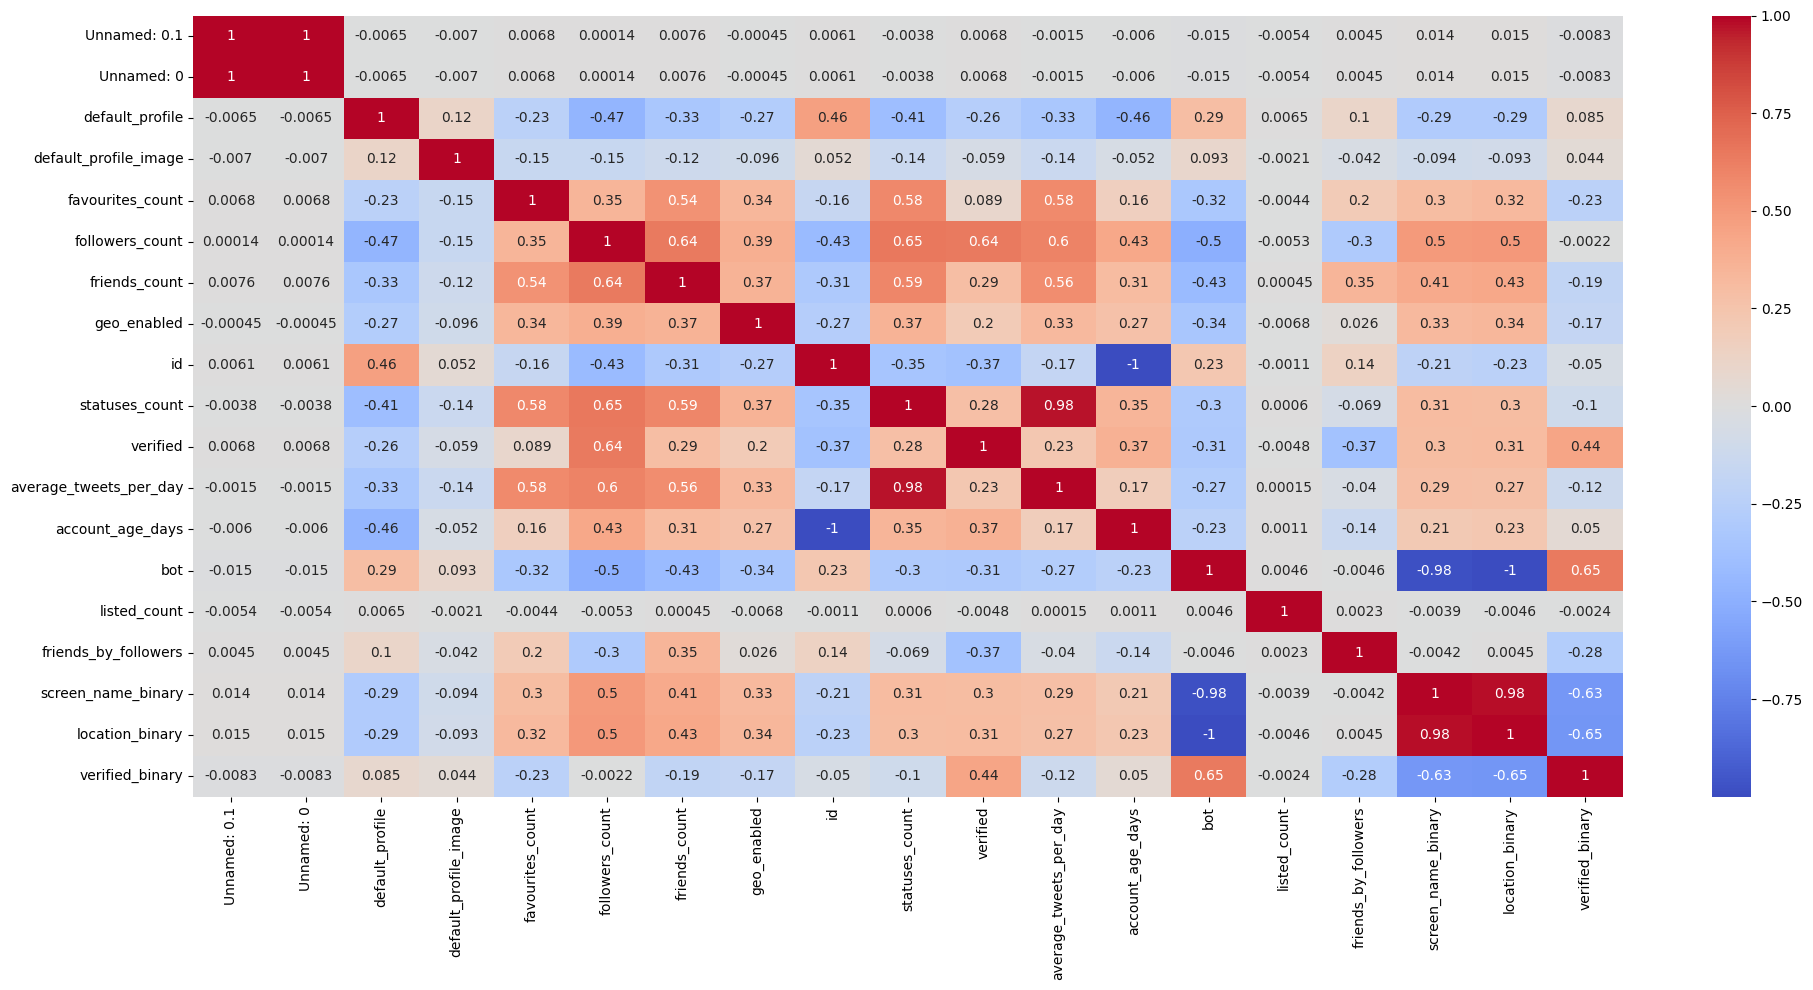

In [12]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(method='spearman'), cmap='coolwarm', annot=True)
plt.tight_layout()
plt.show()

Result:
- There is no correlation between **id, statuses_count, default_profile, default_profile_image** and target variable.
- There is strong correlation between **verified, listed_count, friends_count, followers_count** and target variable.
- We cannot perform correlation for categorical attributes. So we will take **screen_name, name, description, status** into feature engineering. While use **verified, listed_count** for feature extraction.

#### Performing Feature Engineering

In [52]:
# Change this to your path
filepath = 'change/this/path'
file = open(filepath+'training_data.csv', mode='r', encoding='utf-8', errors='ignore')

training_data = pd.read_csv(file)

bag_of_words_bot = r'free|troll|wizard|yes_ofc|fuck|magic|jargon|jack|bonsai|paper|follow|bbb|expos|truthe|kill|free|updates|dunia|virus|RNA|emoji|chick|bang|wow|prison|swag|butt|fake|freak|joke|onlyman|xx|clit|cannabis|ffd|pokem|sex|droop|bbb|bio|XXX|me|cheese|funky|clone|ffd|tweet|face|forget|anony|genie|gorilla|nerd|bot|me|every|yeah|kuck|every|mishear|b0t'
            
training_data['screen_name_binary'] = training_data.screen_name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['name_binary'] = training_data.name.str.contains(bag_of_words_bot, case=False, na=False)
training_data['description_binary'] = training_data.description.str.contains(bag_of_words_bot, case=False, na=False)
training_data['status_binary'] = training_data.status.str.contains(bag_of_words_bot, case=False, na=False)

#### Performing Feature Extraction

In [53]:
training_data['listed_count_binary'] = (training_data.listed_count>20000)==False
features = ['screen_name_binary', 'name_binary', 'description_binary', 'status_binary', 'verified', 'followers_count', 'friends_count', 'statuses_count', 'listed_count_binary', 'bot']

## Implementing Different Models

In [54]:
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

## Decision Tree Classifier

In [55]:
from sklearn.tree import DecisionTreeClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=50, min_samples_split=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.3, random_state=101)


dt = dt.fit(X_train, y_train)
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.7931034482758621
recall_score: 0.887240356083086
precision_score: 0.7170263788968825
accuracy_score: 0.8142857142857143
Trainig Accuracy: 0.84863
Test Accuracy: 0.81429


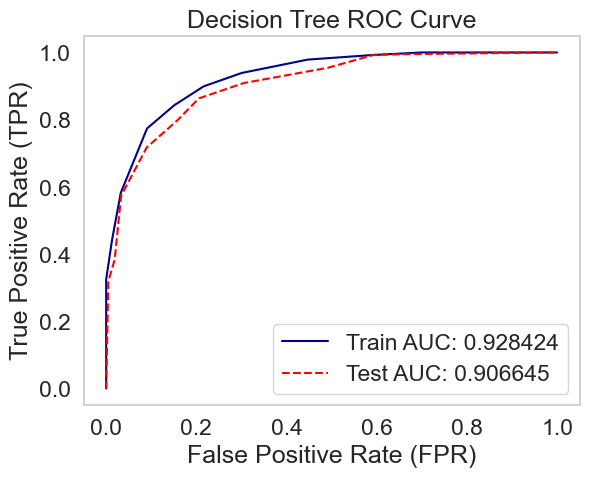

In [17]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = dt.predict_proba(X_train)
scores_test = dt.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_dt_train, tpr_dt_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_dt_test, tpr_dt_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_dt_train, tpr_dt_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_dt_test, tpr_dt_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.title("Decision Tree ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Multinomial Naive Bayes Classifier

In [18]:
from sklearn.naive_bayes import MultinomialNB

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

mnb = MultinomialNB(alpha=0.0009)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

mnb = mnb.fit(X_train, y_train)
y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.7612781954887219
recall_score: 0.6259659969088099
precision_score: 0.9712230215827338
accuracy_score: 0.6976190476190476
Trainig Accuracy: 0.67961
Test Accuracy: 0.69762


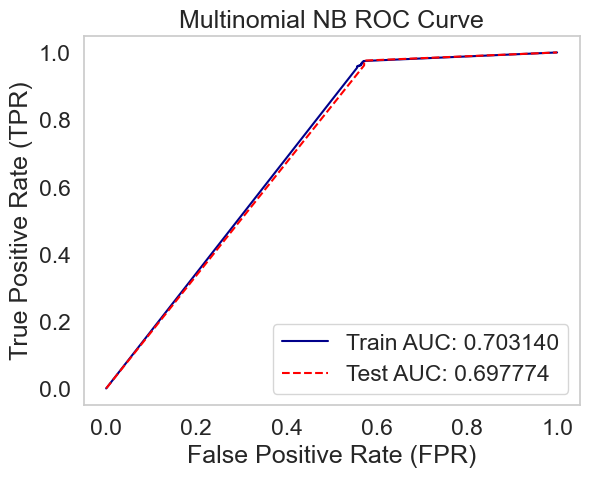

In [19]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mnb.predict_proba(X_train)
scores_test = mnb.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mnb_train, tpr_mnb_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mnb_test, tpr_mnb_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mnb_train, tpr_mnb_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_mnb_test, tpr_mnb_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.title("Multinomial NB ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]

rf = RandomForestClassifier(criterion='entropy', min_samples_leaf=100, min_samples_split=20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)


print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.845869297163995
recall_score: 0.8705583756345178
precision_score: 0.8225419664268585
accuracy_score: 0.8511904761904762
Trainig Accuracy: 0.86357
Test Accuracy: 0.85119


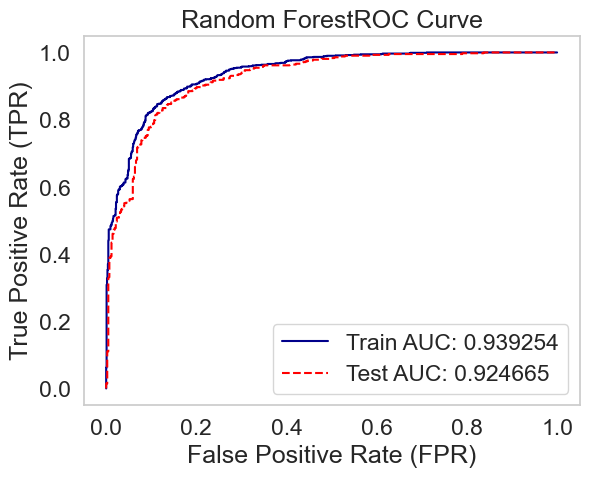

In [21]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = rf.predict_proba(X_train)
scores_test = rf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_rf_train, tpr_rf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_rf_test, tpr_rf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_rf_train, tpr_rf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_rf_test, tpr_rf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.title("Random ForestROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

### ROC Comparison after tuning the baseline model

In [22]:
from sklearn.linear_model import LogisticRegression

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
clf = LogisticRegression(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

clf = clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.7596153846153846
recall_score: 0.6340288924558587
precision_score: 0.947242206235012
accuracy_score: 0.7023809523809523
Trainig Accuracy: 0.69494
Test Accuracy: 0.70238


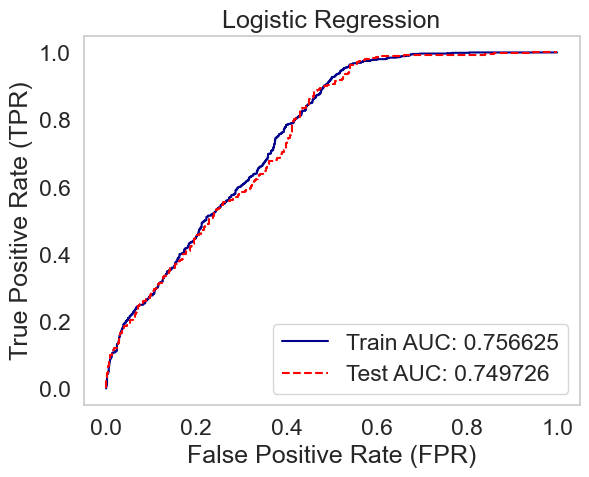

In [23]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = clf.predict_proba(X_train)
scores_test = clf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_clf_train, tpr_clf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_clf_test, tpr_clf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_clf_train, tpr_clf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_clf_train, tpr_clf_train))
plt.plot(fpr_clf_test, tpr_clf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_clf_test, tpr_clf_test))
plt.title("Logistic Regression")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Nearest Neighbors

In [24]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)

nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

print(nca_pipe.score(X_test, y_test))

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

0.8380952380952381
f1_score: 0.7596153846153846
recall_score: 0.6340288924558587
precision_score: 0.947242206235012
accuracy_score: 0.7023809523809523


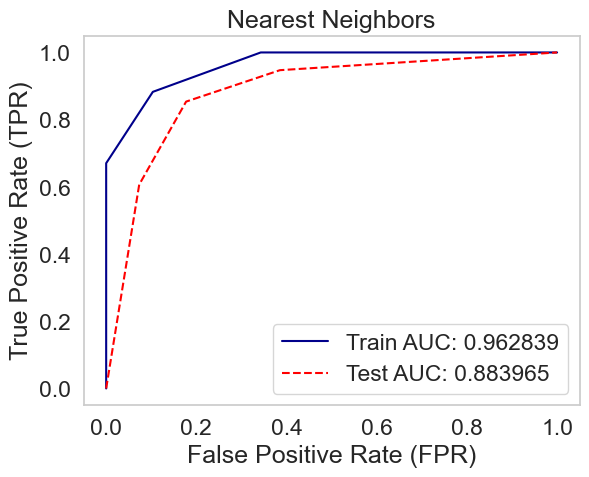

In [25]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = nca_pipe.predict_proba(X_train)
scores_test = nca_pipe.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_nbrs_train, tpr_nbrs_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_nbrs_test, tpr_nbrs_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_nbrs_train, tpr_nbrs_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_nbrs_train, tpr_nbrs_train))
plt.plot(fpr_nbrs_test, tpr_nbrs_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_nbrs_test, tpr_nbrs_test))
plt.title("Nearest Neighbors")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Support Vector Machines

In [26]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn import svm

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


clf_svm = svm.SVC(probability=True)

clf_svm.fit(X_train, y_train)

y_pred_train = clf_svm.predict(X_train)
y_pred_test = clf_svm.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.7206266318537858
recall_score: 0.5655737704918032
precision_score: 0.9928057553956835
accuracy_score: 0.6178571428571429
Trainig Accuracy: 0.59377
Test Accuracy: 0.61786


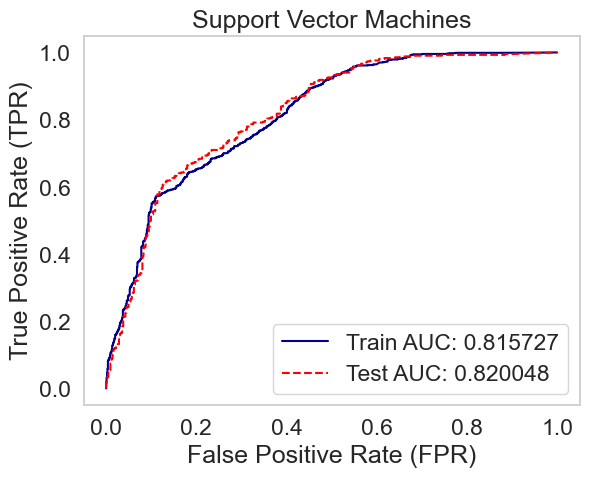

In [27]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = clf_svm.predict_proba(X_train)
scores_test = clf_svm.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    

fpr_clf_svm_train, tpr_clf_svm_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_clf_svm_test, tpr_clf_svm_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_clf_svm_train, tpr_clf_svm_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_clf_svm_train, tpr_clf_svm_train))
plt.plot(fpr_clf_svm_test, tpr_clf_svm_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_clf_svm_test, tpr_clf_svm_test))
plt.title("Support Vector Machines")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Multi-layer Perceptron

In [28]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.3, random_state=101)


mlp_svm = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

mlp_svm.fit(X_train, y_train)

y_pred_train = mlp_svm.predict(X_train)
y_pred_test = mlp_svm.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.7613636363636364
recall_score: 0.6291079812206573
precision_score: 0.9640287769784173
accuracy_score: 0.7
Trainig Accuracy: 0.67461
Test Accuracy: 0.70000


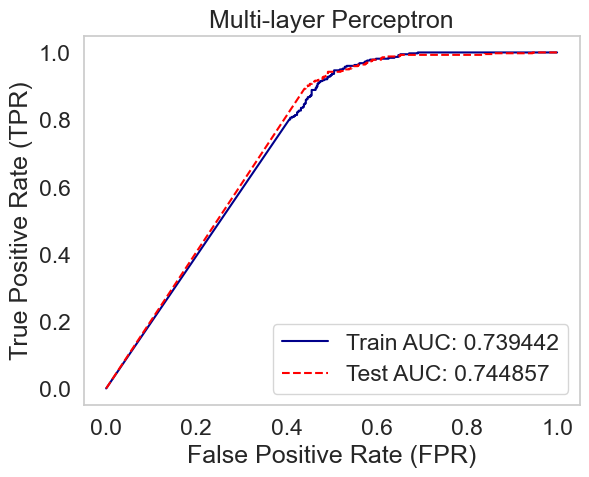

In [29]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = mlp_svm.predict_proba(X_train)
scores_test = mlp_svm.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_mlp_svm_train, tpr_mlp_svm_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_mlp_svm_test, tpr_mlp_svm_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_mlp_svm_train, tpr_mlp_svm_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_mlp_svm_train, tpr_mlp_svm_train))
plt.plot(fpr_mlp_svm_test, tpr_mlp_svm_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_mlp_svm_test, tpr_mlp_svm_test))
plt.title("Multi-layer Perceptron")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Naive Bayes

In [30]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.3, random_state=101)


nb_clf = GaussianNB()


nb_clf.fit(X_train, y_train)

y_pred_train = nb_clf.predict(X_train)
y_pred_test = nb_clf.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.7493163172288058
recall_score: 0.6044117647058823
precision_score: 0.9856115107913669
accuracy_score: 0.6726190476190477
Trainig Accuracy: 0.63886
Test Accuracy: 0.67262


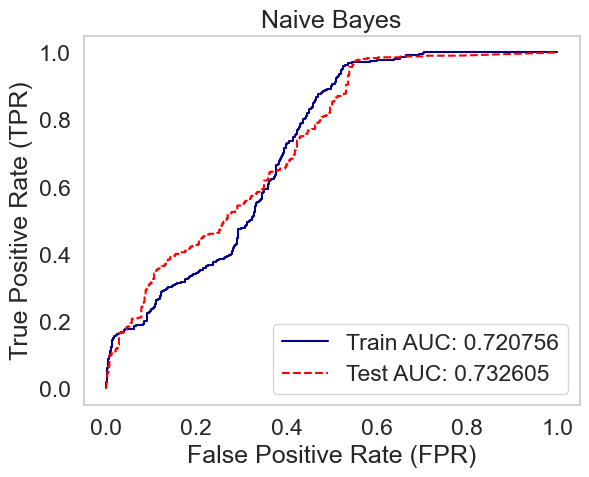

In [31]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = nb_clf.predict_proba(X_train)
scores_test = nb_clf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_nb_clf_train, tpr_nb_clf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_nb_clf_test, tpr_nb_clf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_nb_clf_train, tpr_nb_clf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_nb_clf_train, tpr_nb_clf_train))
plt.plot(fpr_nb_clf_test, tpr_nb_clf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_nb_clf_test, tpr_nb_clf_test))
plt.title("Naive Bayes")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## AdaBoost

In [32]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.3, random_state=101)


ada_boost_clf = AdaBoostClassifier(n_estimators=100, random_state=0)


ada_boost_clf.fit(X_train, y_train)

y_pred_train = ada_boost_clf.predict(X_train)
y_pred_test = ada_boost_clf.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")

print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.8354114713216957
recall_score: 0.8701298701298701
precision_score: 0.8033573141486811
accuracy_score: 0.8428571428571429
Trainig Accuracy: 0.90942
Test Accuracy: 0.84286


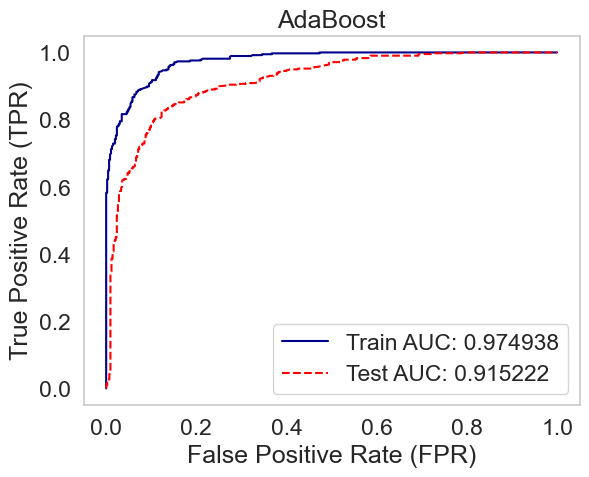

In [33]:
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = ada_boost_clf.predict_proba(X_train)
scores_test = ada_boost_clf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    
fpr_ada_boost_clf_train, tpr_ada_boost_clf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_ada_boost_clf_test, tpr_ada_boost_clf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_ada_boost_clf_train, tpr_ada_boost_clf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_ada_boost_clf_train, tpr_ada_boost_clf_train))
plt.plot(fpr_ada_boost_clf_test, tpr_ada_boost_clf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_ada_boost_clf_test, tpr_ada_boost_clf_test))
plt.title("AdaBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## XgBoost

In [34]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

X = training_data[features].iloc[:,:-1]
y = training_data[features].iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)


xgboost_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)


xgboost_clf.fit(X_train, y_train)

y_pred_train = xgboost_clf.predict(X_train)
y_pred_test = xgboost_clf.predict(X_test)

print(f"f1_score: {f1_score(y_pred_test, y_test)}")
print(f"recall_score: {recall_score(y_pred_test, y_test)}")
print(f"precision_score: {precision_score(y_pred_test, y_test)}")
print(f"accuracy_score: {accuracy_score(y_pred_test, y_test)}")


print("Trainig Accuracy: %.5f" %accuracy_score(y_train, y_pred_train))
print("Test Accuracy: %.5f" %accuracy_score(y_test, y_pred_test))

f1_score: 0.865127582017011
recall_score: 0.8768472906403941
precision_score: 0.8537170263788969
accuracy_score: 0.8678571428571429
Trainig Accuracy: 0.89371
Test Accuracy: 0.86786


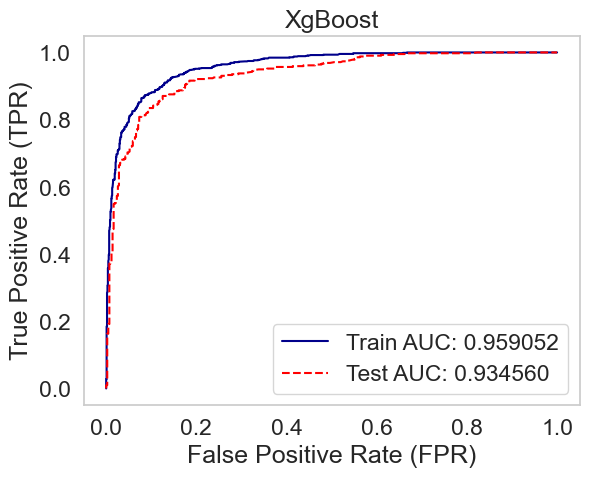

In [35]:
from sklearn.metrics import recall_score
sns.set_style("whitegrid", {'axes.grid' : False})

scores_train = xgboost_clf.predict_proba(X_train)
scores_test = xgboost_clf.predict_proba(X_test)

y_scores_train = []
y_scores_test = []
for i in range(len(scores_train)):
    y_scores_train.append(scores_train[i][1])

for i in range(len(scores_test)):
    y_scores_test.append(scores_test[i][1])
    

fpr_xgboost_clf_train, tpr_xgboost_clf_train, _ = roc_curve(y_train, y_scores_train, pos_label=1)
fpr_xgboost_clf_test, tpr_xgboost_clf_test, _ = roc_curve(y_test, y_scores_test, pos_label=1)

plt.plot(fpr_xgboost_clf_train, tpr_xgboost_clf_train, color='darkblue', label='Train AUC: %5f' %auc(fpr_xgboost_clf_train, tpr_xgboost_clf_train))
plt.plot(fpr_xgboost_clf_test, tpr_xgboost_clf_test, color='red', ls='--', label='Test AUC: %5f' %auc(fpr_xgboost_clf_test, tpr_xgboost_clf_test))
plt.title("XgBoost")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

## Implemented Classifier

f1_score: 0.9044776119402984
recall_score: 0.8256130790190735
precision_score: 1.0
accuracy_score: 0.9049034175334324
Train Accuracy:  0.9354990583804144
f1_score: 0.921090387374462
recall_score: 0.8537234042553191
precision_score: 1.0
accuracy_score: 0.9193548387096774
Test Accuracy:  0.9193548387096774


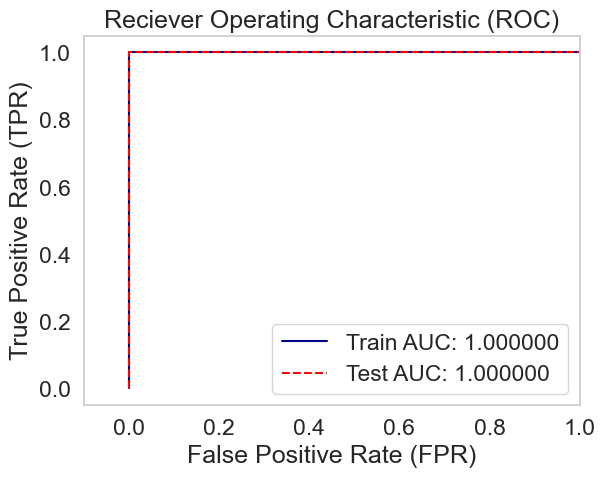

In [42]:
import time
from sklearn import metrics

class TwitterBot(object):
    def __init__(self):
        pass

    def perform_train_test_split(df):
        msk = np.random.rand(len(df)) < 0.75
        train, test = df[msk], df[~msk]
        X_train, y_train = train, train.iloc[:,-1]
        X_test, y_test = test, test.iloc[:, -1]
        return (X_train, y_train, X_test, y_test)

    def bot_prediction_algorithm(df):
        # creating copy of dataframe
        train_df = df.copy()
        # performing feature engineering on id and verfied columns
        # converting id to int
        train_df['id'] = train_df.id.apply(lambda x: int(x))
        train_df['followers_count'] = train_df.followers_count.apply(lambda x: 0 if x=='None' else int(x))
        train_df['friends_count'] = train_df.friends_count.apply(lambda x: 0 if x=='None' else int(x))
        if train_df.shape[0]>600:
            #bag_of_words_for_bot
            bag_of_words_bot = r'free|troll|wizard|yes_ofc|fuck|magic|jargon|jack|bonsai|paper|follow|bbb|expos|truthe|kill|free|updates|dunia|virus|RNA|emoji|chick|bang|wow|prison|swag|butt|fake|freak|joke|onlyman|xx|clit|cannabis|ffd|pokem|sex|droop|bbb|bio|XXX|me|cheese|funky|clone|ffd|tweet|face|forget|anony|genie|gorilla|nerd|bot|me|every|yeah|kuck|every|mishear|b0t'
        else:
            # bag_of_words_for_bot
            bag_of_words_bot = r'bot|b0t|cannabis|mishear|updates every'

        # converting verified into vectors
        train_df['verified'] = train_df.verified.apply(lambda x: 1 if ((x == True) or x == 'TRUE') else 0)

        # check if the name contains bot or screenname contains b0t (In my case, there is not collumn 'name', only screen_name)
        condition = (
                     (train_df.description.str.contains(bag_of_words_bot, case=False, na=False)) |
                     (train_df.screen_name.str.contains(bag_of_words_bot, case=False, na=False)) 
            )  # these all are bots
        predicted_df = train_df[condition]  # these all are bots
        predicted_df.bot = 1
        predicted_df = predicted_df[['id', 'bot']]

        # check if the user is verified
        verified_df = train_df[~condition]
        condition = (verified_df.verified == 1)  # these all are nonbots
        predicted_df1 = verified_df[condition][['id', 'bot']]
        predicted_df1.bot = 0
        predicted_df = pd.concat([predicted_df, predicted_df1])

        # check if description contains buzzfeed
        buzzfeed_df = verified_df[~condition]
        condition = (buzzfeed_df.description.str.contains("buzzfeed", case=False, na=False))  # these all are nonbots
        predicted_df1 = buzzfeed_df[buzzfeed_df.description.str.contains("buzzfeed", case=False, na=False)][['id', 'bot']]
        predicted_df1.bot = 0
        predicted_df = pd.concat([predicted_df, predicted_df1])

        # check if listed_count>16000
        listed_count_df = buzzfeed_df[~condition]
        listed_count_df.listed_count = listed_count_df.listed_count.apply(lambda x: 0 if x == 'None' else x)
        listed_count_df.listed_count = listed_count_df.listed_count.apply(lambda x: int(x))
        condition = (listed_count_df.listed_count > 16000)  # these all are nonbots
        predicted_df1 = listed_count_df[condition][['id', 'bot']]
        predicted_df1.bot = 0
        predicted_df = pd.concat([predicted_df, predicted_df1])

        #remaining
        predicted_df1 = listed_count_df[~condition][['id', 'bot']]
        predicted_df1.bot = 0 # these all are nonbots
        predicted_df = pd.concat([predicted_df, predicted_df1])
        return predicted_df

    def get_predicted_and_true_values(features, target):
        y_pred, y_true = TwitterBot.bot_prediction_algorithm(features).bot.tolist(), target.tolist()
        return (y_pred, y_true)

    def get_metrics_score(df):
        (X_train, y_train, X_test, y_test) = TwitterBot.perform_train_test_split(df)
        # predictions on training data
        y_pred_train, y_true_train = TwitterBot.get_predicted_and_true_values(X_train, y_train)
        train_acc = metrics.accuracy_score(y_pred_train, y_true_train)
        #predictions on test data
        y_pred_test, y_true_test = TwitterBot.get_predicted_and_true_values(X_test, y_test)
        print(f"f1_score: {f1_score(y_pred_test, y_true_test)}")
        print(f"recall_score: {recall_score(y_pred_test, y_true_test)}")
        print(f"precision_score: {precision_score(y_pred_test, y_true_test)}")
        print(f"accuracy_score: {accuracy_score(y_pred_test, y_true_test)}")
        test_acc = metrics.accuracy_score(y_pred_test, y_true_test)
        return (train_acc, test_acc)

    def plot_roc_curve(df):
        (X_train, y_train, X_test, y_test) = TwitterBot.perform_train_test_split(df)
        # Train ROC
        y_pred_train, y_true = TwitterBot.get_predicted_and_true_values(X_train, y_train)
        scores = np.linspace(start=0.01, stop=0.9, num=len(y_true))
        fpr_train, tpr_train, threshold = metrics.roc_curve(y_pred_train, scores, pos_label=0)
        plt.plot(fpr_train, tpr_train, label='Train AUC: %5f' % metrics.auc(fpr_train, tpr_train), color='darkblue')
        #Test ROC
        y_pred_test, y_true = TwitterBot.get_predicted_and_true_values(X_test, y_test)
        scores = np.linspace(start=0.01, stop=0.9, num=len(y_true))
        fpr_test, tpr_test, threshold = metrics.roc_curve(y_pred_test, scores, pos_label=0)
        plt.plot(fpr_test,tpr_test, label='Test AUC: %5f' %metrics.auc(fpr_test,tpr_test), ls='--', color='red')
        #Misc
        plt.xlim([-0.1,1])
        plt.title("Reciever Operating Characteristic (ROC)")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.legend(loc='lower right')
        plt.show()


if __name__ == '__main__':
    start = time.time()
    # Change this to your path
    filepath = 'change/this/path/'
    train_df = pd.read_csv(f"{filepath}/training_data.csv")
    test_df = pd.read_csv(f"{filepath}/test_data.csv", sep='\t')
    print("Train Accuracy: ", TwitterBot.get_metrics_score(train_df)[0])
    print("Test Accuracy: ", TwitterBot.get_metrics_score(train_df)[1])

    #predicting test data results
    predicted_df = TwitterBot.bot_prediction_algorithm(test_df)
    #plotting the ROC curve
    TwitterBot.plot_roc_curve(train_df)

## ROC Comparison

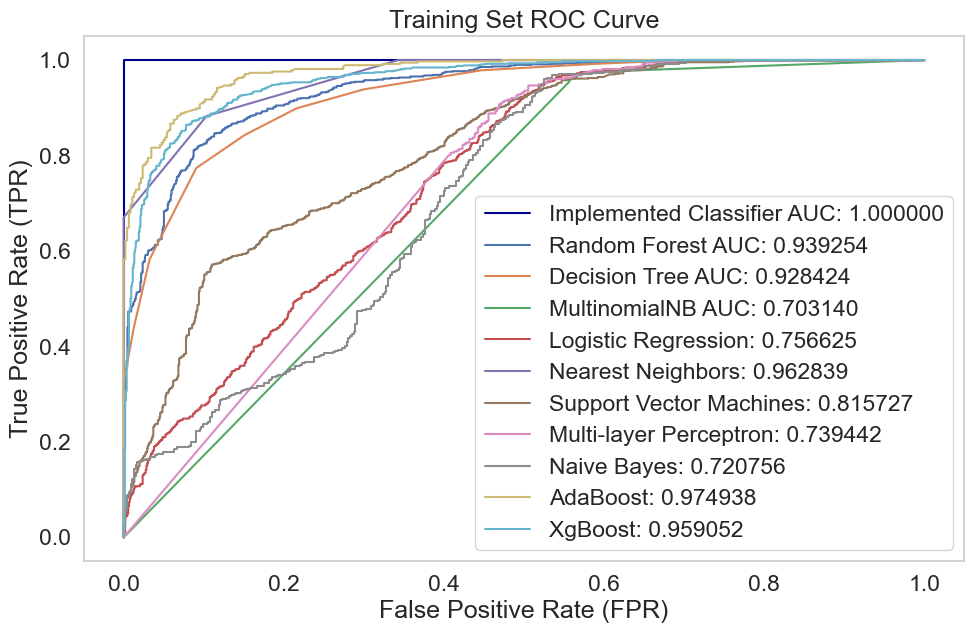

In [37]:
plt.figure(figsize=(25, 15))
(X_train, y_train, X_test, y_test) = TwitterBot.perform_train_test_split(df)
#Train ROC
y_pred_train, y_true = TwitterBot.get_predicted_and_true_values(X_train, y_train)
scores = np.linspace(start=0, stop=1, num=len(y_true))
fpr_botc_train, tpr_botc_train, threshold = metrics.roc_curve(y_pred_train, scores, pos_label=0)

#Test ROC
y_pred_test, y_true = TwitterBot.get_predicted_and_true_values(X_test, y_test)
scores = np.linspace(start=0, stop=1, num=len(y_true))
fpr_botc_test, tpr_botc_test, threshold = metrics.roc_curve(y_pred_test, scores, pos_label=0)

#Train ROC
plt.subplot(2,2,1)
plt.plot(fpr_botc_train, tpr_botc_train, label='Implemented Classifier AUC: %5f' % metrics.auc(fpr_botc_train,tpr_botc_train), color='darkblue')
plt.plot(fpr_rf_train, tpr_rf_train, label='Random Forest AUC: %5f' %auc(fpr_rf_train, tpr_rf_train))
plt.plot(fpr_dt_train, tpr_dt_train, label='Decision Tree AUC: %5f' %auc(fpr_dt_train, tpr_dt_train))
plt.plot(fpr_mnb_train, tpr_mnb_train, label='MultinomialNB AUC: %5f' %auc(fpr_mnb_train, tpr_mnb_train))
plt.plot(fpr_clf_train, tpr_clf_train, label='Logistic Regression: %5f' %auc(fpr_clf_train, tpr_clf_train))
plt.plot(fpr_nbrs_train, tpr_nbrs_train, label='Nearest Neighbors: %5f' %auc(fpr_nbrs_train, tpr_nbrs_train))
plt.plot(fpr_clf_svm_train, tpr_clf_svm_train, label='Support Vector Machines: %5f' %auc(fpr_clf_svm_train, tpr_clf_svm_train))
plt.plot(fpr_mlp_svm_train, tpr_mlp_svm_train, label='Multi-layer Perceptron: %5f' %auc(fpr_mlp_svm_train, tpr_mlp_svm_train))
plt.plot(fpr_nb_clf_train, tpr_nb_clf_train, label='Naive Bayes: %5f' %auc(fpr_nb_clf_train, tpr_nb_clf_train))
plt.plot(fpr_ada_boost_clf_train, tpr_ada_boost_clf_train, label='AdaBoost: %5f' %auc(fpr_ada_boost_clf_train, tpr_ada_boost_clf_train))
plt.plot(fpr_xgboost_clf_train, tpr_xgboost_clf_train, label='XgBoost: %5f' %auc(fpr_xgboost_clf_train, tpr_xgboost_clf_train))


plt.title("Training Set ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')

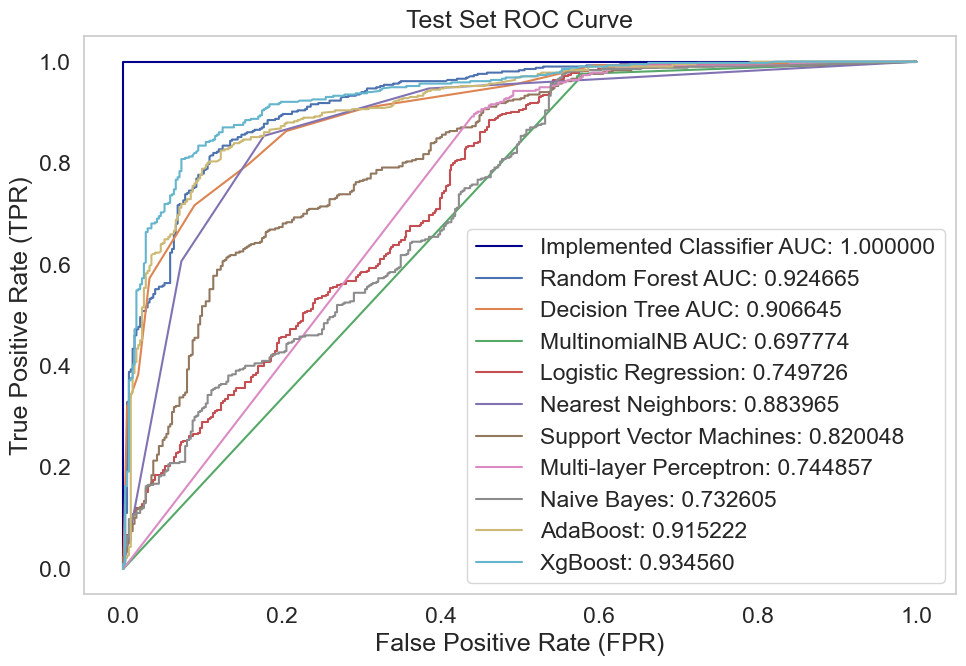

In [38]:
plt.figure(figsize=(10, 7))
#Test ROC
plt.plot(fpr_botc_test,tpr_botc_test, label='Implemented Classifier AUC: %5f' %metrics.auc(fpr_botc_test,tpr_botc_test), color='darkblue')
plt.plot(fpr_rf_test, tpr_rf_test, label='Random Forest AUC: %5f' %auc(fpr_rf_test, tpr_rf_test))
plt.plot(fpr_dt_test, tpr_dt_test, label='Decision Tree AUC: %5f' %auc(fpr_dt_test, tpr_dt_test))
plt.plot(fpr_mnb_test, tpr_mnb_test, label='MultinomialNB AUC: %5f' %auc(fpr_mnb_test, tpr_mnb_test))
plt.plot(fpr_clf_test, tpr_clf_test, label='Logistic Regression: %5f' %auc(fpr_clf_test, tpr_clf_test))
plt.plot(fpr_nbrs_test, tpr_nbrs_test, label='Nearest Neighbors: %5f' %auc(fpr_nbrs_test, tpr_nbrs_test))
plt.plot(fpr_clf_svm_test, tpr_clf_svm_test, label='Support Vector Machines: %5f' %auc(fpr_clf_svm_test, tpr_clf_svm_test))
plt.plot(fpr_mlp_svm_test, tpr_mlp_svm_test, label='Multi-layer Perceptron: %5f' %auc(fpr_mlp_svm_test, tpr_mlp_svm_test))
plt.plot(fpr_nb_clf_test, tpr_nb_clf_test, label='Naive Bayes: %5f' %auc(fpr_nb_clf_test, tpr_nb_clf_test))
plt.plot(fpr_ada_boost_clf_test, tpr_ada_boost_clf_test, label='AdaBoost: %5f' %auc(fpr_ada_boost_clf_test, tpr_ada_boost_clf_test))
plt.plot(fpr_xgboost_clf_test, tpr_xgboost_clf_test, label='XgBoost: %5f' %auc(fpr_xgboost_clf_test, tpr_xgboost_clf_test))
plt.title("Test Set ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right')
plt.tight_layout()